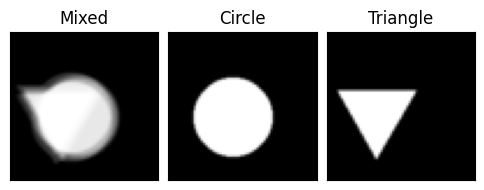

In [4]:
from PIL import Image, ImageDraw
import numpy as np
from random import randrange, uniform
from scipy.signal import convolve2d

%matplotlib inline
import matplotlib.pyplot as plt

def draw_random_circle(image, image_size, color, min_width=64, max_width=128):
    width = randrange(min_width, max_width)
    x0, y0 = randrange(0, image_size-width), randrange(0, image_size-width)
    
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0, y0, x0+width, y0+width), fill=color, outline=(0, 0, 0), width=0)
    
def draw_random_triangle(image, image_size, color, min_width=64, max_width=128):
    width = randrange(min_width, max_width)
    x0, y0 = randrange(0, image_size-width), randrange(0, image_size-width)
    x1, y1 = x0+(width//2), int(y0+(width*3**0.5)/2)
    x2, y2 = x0+width, y0
    draw = ImageDraw.Draw(image)
    draw.polygon(((x0, y0), (x1, y1), (x2, y2)), fill=color, outline=(0, 0, 0), width=0)

def sigmoid(x):
    return 1/(1 + np.exp(-x) + 1e-6)

def generate_image(image_size=128):
    # draw random circle
    image_c = Image.new('RGB', (image_size*2, image_size*2), (0, 0, 0))
    draw_random_circle(image_c, image_size*2, 
                       min_width=int(image_size*2*0.4), max_width=int(image_size*2*0.6),
                       color=(255, 255, 255))
    image_c = np.array(image_c).astype(np.float32)/255
    # draw random triangle
    image_t = Image.new('RGB', (image_size*2, image_size*2), (0, 0, 0))
    draw_random_triangle(image_t, image_size*2, 
                         min_width=int(image_size*2*0.4), max_width=int(image_size*2*0.6),
                         color=(255, 255, 255))
    image_t = np.array(image_t).astype(np.float32)/255

    # resize image
    image_c = Image.fromarray(np.uint8(image_c*0.5*255))
    image_t = Image.fromarray(np.uint8(image_t*0.5*255))
    image_c = image_c.resize((image_size, image_size), resample=Image.BILINEAR)
    image_t = image_t.resize((image_size, image_size), resample=Image.BILINEAR)
    image_c = np.array(image_c)[:, :, 0]
    image_t = np.array(image_t)[:, :, 0]
    image = image_c + image_t
    
    kernel = np.array( # distortion kernel
        [[1.0, 1.0, 0.0, 0.0, 0.0],
         [0.0, 0.0, 0.5, 1.0, 0.5],
         [0.0, 0.0, 0.0, 0.5, 1.0],
         [0.0, 0.0, 0.5, 1.0, 0.5],
         [1.0, 1.0, 0.0, 0.0, 0.0]]
    )
    if uniform(0, 1) < 0.5:
        kernel = kernel[::-1, ::-1]
    
    image = image/255
    image = sigmoid(image*6)
    image = (image - np.min(image))/ (np.max(image) - np.min(image))
    image = convolve2d(image, kernel, mode='same')

    return [image.reshape(image.shape[0], image.shape[1], 1), 
            image_c.reshape(image_c.shape[0], image_c.shape[1], 1), 
            image_t.reshape(image_t.shape[0], image_t.shape[1], 1)]

sample, circle, triangle = generate_image(64)

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(6, 6))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 3),
                 axes_pad=0.1,
                 )

labels = ['Mixed', 'Circle', 'Triangle']
for ax, im, label in zip(grid, [sample, circle, triangle], labels):
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im, cmap='gray')

plt.show()

import os



In [5]:
import pickle

num_samples = 150000
image_size = 64

data = []
for _ in range(num_samples):
    data.append(generate_image(image_size))

file_name = '../data/single_channel_nonlinear_mixing_tri_circ.pickle'
with open(file=file_name, mode='wb') as file:
    pickle.dump(data, file)